
---
# **CUSTOMER LIFETIME VALUE (CLV)**
---
# **PART.1**
### **1. Data Preperation**
### **2. Average Order Value**
*   ### average_order_value = total_price /total_transaction 

### **3. Purchase Frequency** 
*   ### total_transaction / total_number_of_customers

### **4. Repeat Rate & Churn Rate** 

### **5. Profit Margin** 
*   ### profit_margin =  total_price * 0.10

### **6. Customer Value** 
*   ### customer_value = average_order_value * purchase_frequency

### **7. Customer Lifetime Value** 
*   ### CLTV = (customer_value / churn_rate) x profit_margin

### **8. Creating Segments**

### **9. Functionalization - I**
# **PART.2**
### **10. Expected Number of Transaction with BG-NBD Model**

### **11. Expected Average Profit with Gamma-Gamma Model**

### **12. Calculation of CLTV with BG-NBD and Gamma-Gamma Model**

### **13. Creating Segments by CLTV**

### **14. Functionalization - II**



---
# **PART.1**
---


# **1. Data Preperation**

### https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

### The dataset named Online Retail II includes the sales of an UK-based online store between 01/12/2009 - 09/12/2011.

## **Variables**
###Information on the data contained in the variables in the dataset is given below.
### **InvoiceNo:** Invoice number. The unique number of each transaction, namely the invoice. Aborted operation if it starts with C.
### **StockCode:** Product code. Unique number for each product.
### **Description:** Product name
### **Quantity:** Number of products. It expresses how many of the products on the invoices have been sold.
### **InvoiceDate:** Invoice date and time.
### **UnitPrice:** Product price (in GBP)
### **CustomerID:** Unique customer number
### **Country:** Country where the customer lives.


---



In [121]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [123]:
df_ = pd.read_excel("/content/online_retail_II_20092010.xlsx")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [124]:
#Row number of dataframe. Alternative version: len(df)
df.shape[0]

525461

In [125]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [126]:
df = df[~df["Invoice"].str.contains("C", na=False)]

### If the invoice contains the letter **"C"**, its type is **Canceled**.

### **Here is a breakdown of how the code works:**


---


### **df["Invoice"].str.contains("C", na=False)** creates a boolean mask that is True for rows where the "Invoice" column contains the letter "C", and False otherwise. The na=False parameter specifies that missing values (NaN) should be treated as False.

### **The tilde ( ~ ) operator negates the boolean mask, so it is True for rows that do not contain the letter "C", and False for rows that do contain the letter "C".**

### The boolean mask is used to index the dataframe df, so df[~ df["Invoice"].str.contains("C", na=False)] returns a new dataframe that only contains rows where the "Invoice" column **does not contain** the letter "C".

In [127]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,515255.0000,10.9566,104.3540,-9600.0000,1.0000,3.0000,10.0000,19152.0000
Price,515255.0000,3.9564,127.6886,-53594.3600,1.2500,2.1000,4.2100,25111.0900
Customer ID,407695.0000,15368.5041,1679.7957,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [128]:
df = df[(df['Quantity'] > 0)]

In [129]:
df.dropna(inplace=True)

In [130]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.6500,13085.0000,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.9500,13085.0000,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.5500,13085.0000,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.7500,13085.0000,United Kingdom


In [131]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [132]:
cltv_gb = df.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(),
                                        'Quantity': lambda x: x.sum(),
                                        'TotalPrice': lambda x: x.sum()})

cltv_gb.columns = ['total_transaction', 'total_unit', 'total_price']

In [133]:
cltv_gb

,total_transaction,total_unit,total_price
Customer ID,,,
12346.0000,11,70,372.8600
12347.0000,2,828,1323.3200
12348.0000,1,373,222.1600
12349.0000,3,993,2671.1400
12351.0000,1,261,300.9300
...,...,...,...
18283.0000,6,336,641.7700
18284.0000,1,494,461.6800
18285.0000,1,145,427.0000


---
# **2. Average Order Value (average_order_value = total_price / total_transaction)**


In [134]:
cltv_gb.head()
cltv_gb["average_order_value"] = cltv_gb["total_price"] / cltv_gb["total_transaction"]
cltv_gb

,total_transaction,total_unit,total_price,average_order_value
Customer ID,,,,
12346.0000,11,70,372.8600,33.8964
12347.0000,2,828,1323.3200,661.6600
12348.0000,1,373,222.1600,222.1600
12349.0000,3,993,2671.1400,890.3800
12351.0000,1,261,300.9300,300.9300
...,...,...,...,...
18283.0000,6,336,641.7700,106.9617
18284.0000,1,494,461.6800,461.6800
18285.0000,1,145,427.0000,427.0000


---
# **3. Purchase Frequency (total_transaction / total_number_of_customers)**


In [135]:
cltv_gb["purchase_frequency"] = cltv_gb["total_transaction"] / cltv_gb.shape[0]
cltv_gb

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency
Customer ID,,,,,
12346.0000,11,70,372.8600,33.8964,0.0025
12347.0000,2,828,1323.3200,661.6600,0.0005
12348.0000,1,373,222.1600,222.1600,0.0002
12349.0000,3,993,2671.1400,890.3800,0.0007
12351.0000,1,261,300.9300,300.9300,0.0002
...,...,...,...,...,...
18283.0000,6,336,641.7700,106.9617,0.0014
18284.0000,1,494,461.6800,461.6800,0.0002
18285.0000,1,145,427.0000,427.0000,0.0002


---

# **4. Repeat Rate & Churn Rate**


In [136]:
repeat_rate = cltv_gb[cltv_gb["total_transaction"] > 1].shape[0] / cltv_gb.shape[0]

churn_rate = 1 - repeat_rate

---

# **5. Profit Margin (profit_margin =  total_price * 0.10)**


In [137]:
cltv_gb['profit_margin'] = cltv_gb['total_price'] * 0.10
cltv_gb

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin
Customer ID,,,,,,
12346.0000,11,70,372.8600,33.8964,0.0025,37.2860
12347.0000,2,828,1323.3200,661.6600,0.0005,132.3320
12348.0000,1,373,222.1600,222.1600,0.0002,22.2160
12349.0000,3,993,2671.1400,890.3800,0.0007,267.1140
12351.0000,1,261,300.9300,300.9300,0.0002,30.0930
...,...,...,...,...,...,...
18283.0000,6,336,641.7700,106.9617,0.0014,64.1770
18284.0000,1,494,461.6800,461.6800,0.0002,46.1680
18285.0000,1,145,427.0000,427.0000,0.0002,42.7000


# **6. Customer Value (customer_value = average_order_value * purchase_frequency)**

In [138]:
cltv_gb['customer_value'] = cltv_gb['average_order_value'] * cltv_gb["purchase_frequency"]
cltv_gb

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value
Customer ID,,,,,,,
12346.0000,11,70,372.8600,33.8964,0.0025,37.2860,0.0864
12347.0000,2,828,1323.3200,661.6600,0.0005,132.3320,0.3068
12348.0000,1,373,222.1600,222.1600,0.0002,22.2160,0.0515
12349.0000,3,993,2671.1400,890.3800,0.0007,267.1140,0.6192
12351.0000,1,261,300.9300,300.9300,0.0002,30.0930,0.0698
...,...,...,...,...,...,...,...
18283.0000,6,336,641.7700,106.9617,0.0014,64.1770,0.1488
18284.0000,1,494,461.6800,461.6800,0.0002,46.1680,0.1070
18285.0000,1,145,427.0000,427.0000,0.0002,42.7000,0.0990


# **7. Customer Lifetime Value (CLTV = (customer_value / churn_rate) x profit_margin)**

In [139]:
cltv_gb["cltv"] = (cltv_gb["customer_value"] / churn_rate) * cltv_gb["profit_margin"]

cltv_gb.sort_values(by="cltv", ascending=False)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
18102.0000,89,124216,349164.3500,3923.1949,0.0206,34916.4350,80.9375,8579573.7728
14646.0000,78,170342,248396.5000,3184.5705,0.0181,24839.6500,57.5792,4342070.4583
14156.0000,102,108107,196566.7400,1927.1249,0.0236,19656.6740,45.5648,2719105.0862
14911.0000,205,69722,152147.5700,742.1833,0.0475,15214.7570,35.2683,1629055.8098
13694.0000,94,125893,131443.1900,1398.3318,0.0218,13144.3190,30.4690,1215855.8900
...,...,...,...,...,...,...,...,...
15913.0000,1,3,6.3000,6.3000,0.0002,0.6300,0.0015,0.0028
13788.0000,1,1,3.7500,3.7500,0.0002,0.3750,0.0009,0.0010
14095.0000,1,1,2.9500,2.9500,0.0002,0.2950,0.0007,0.0006


# **8. Creating Segments**

In [140]:
cltv_gb.sort_values(by="cltv", ascending=False).tail()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
15913.0000,1,3,6.3000,6.3000,0.0002,0.6300,0.0015,0.0028
13788.0000,1,1,3.7500,3.7500,0.0002,0.3750,0.0009,0.0010
14095.0000,1,1,2.9500,2.9500,0.0002,0.2950,0.0007,0.0006
14103.0000,1,5,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000
14827.0000,1,5,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000



### **Here is a breakdown of how the code works:**


---


### **pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])** creates four segments of customers based on their CLTV. 
### The pd.qcut() function is used to divide the values of the "cltv" column into four **equal-sized bins**, and the labels parameter is used to assign the labels **"D", "C", "B",** and **"A"** to the four segments in ascending order.

In [141]:
cltv_gb.sort_values(by="cltv", ascending=False).tail()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
15913.0000,1,3,6.3000,6.3000,0.0002,0.6300,0.0015,0.0028
13788.0000,1,1,3.7500,3.7500,0.0002,0.3750,0.0009,0.0010
14095.0000,1,1,2.9500,2.9500,0.0002,0.2950,0.0007,0.0006
14103.0000,1,5,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000
14827.0000,1,5,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000


In [142]:
cltv_gb["segment"] = pd.qcut(cltv_gb["cltv"], 4, labels=["D", "C", "B", "A"])

In [143]:
cltv_gb.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
Customer ID,,,,,,,,,
18102.0000,89,124216,349164.3500,3923.1949,0.0206,34916.4350,80.9375,8579573.7728,A
14646.0000,78,170342,248396.5000,3184.5705,0.0181,24839.6500,57.5792,4342070.4583,A
14156.0000,102,108107,196566.7400,1927.1249,0.0236,19656.6740,45.5648,2719105.0862,A
14911.0000,205,69722,152147.5700,742.1833,0.0475,15214.7570,35.2683,1629055.8098,A
13694.0000,94,125893,131443.1900,1398.3318,0.0218,13144.3190,30.4690,1215855.8900,A


In [144]:
cltv_gb.groupby("segment").agg({"count", "mean", "sum"})

total_transaction              total_unit                total_price                    average_order_value                   purchase_frequency              profit_margin                   customer_value                       cltv                    
                     mean    sum count       mean      sum count        mean          sum count                mean         sum count               mean    sum count          mean         sum count           mean       sum count       mean           sum count
segment                                                                                                                                                                                                                                                            
D                  1.2289   1326  1079   109.0046   117616  1079    178.1883  192265.1300  1079            157.3730 169805.4655  1079             0.0003 0.3074  1079       17.8188  19226.5130  1079         0.0413   44.5677  1079     2.6407     2849.3279  1079
C                  2.0037   2160  1078   283.0566   305135  1078    475.8965  513016.4530  1078            294.4549 317422.3551  1078             0.0005 0.5007  1078       47.5897  51301.6453  1078         0.1103  118.9190  1078    16.8685    18184.2634  1078
B                  3.7690   4063  1078   680.1586   733211  1078   1131.3592 1219605.2000  1078            389.7283 420127.1237  1078             0.0009 0.9418  1078      113.1359 121960.5200  1078         0.2623  282.7087  1078    96.0574   103549.8633  1078
A                 10.8119  11666  1079  4062.3373  4383262  1079   6401.4055 6907116.4910  1079            670.9659 723972.2235  1079             0.0025 2.7042  1079      640.1405 690711.6491  1079         1.4839 1601.0933  1079 23408.0584 25257295.0412  1079

In [145]:
cltv_gb.to_csv("cltv_gb.csv")

# **9. Functionalization - I**

In [146]:
def cltv_Basic(dataframe, profit=0.10):

    # Data Preparation
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[(dataframe['Quantity'] > 0)]
    dataframe.dropna(inplace=True)
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    cltv_gb = dataframe.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(),
                                                   'Quantity': lambda x: x.sum(),
                                                   'TotalPrice': lambda x: x.sum()})
    cltv_gb.columns = ['total_transaction', 'total_unit', 'total_price']
    # avg_order_value
    cltv_gb['avg_order_value'] = cltv_gb['total_price'] / cltv_gb['total_transaction']
    # purchase_frequency
    cltv_gb["purchase_frequency"] = cltv_gb['total_transaction'] / cltv_gb.shape[0]
    # repeat rate & churn rate
    repeat_rate = cltv_gb[cltv_gb.total_transaction > 1].shape[0] / cltv_gb.shape[0]
    churn_rate = 1 - repeat_rate
    # profit_margin
    cltv_gb['profit_margin'] = cltv_gb['total_price'] * profit
    # Customer Value
    cltv_gb['customer_value'] = (cltv_gb['avg_order_value'] * cltv_gb["purchase_frequency"])
    # Customer Lifetime Value
    cltv_gb['cltv'] = (cltv_gb['customer_value'] / churn_rate) * cltv_gb['profit_margin']
    # Segment
    cltv_gb["segment"] = pd.qcut(cltv_gb["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_gb

In [147]:
df = df_.copy()
clv_basic = cltv_Basic(df)

In [148]:
clv_basic

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
Customer ID,,,,,,,,,
12346.0000,11,70,372.8600,33.8964,0.0025,37.2860,0.0864,9.7836,C
12347.0000,2,828,1323.3200,661.6600,0.0005,132.3320,0.3068,123.2355,B
12348.0000,1,373,222.1600,222.1600,0.0002,22.2160,0.0515,3.4733,D
12349.0000,3,993,2671.1400,890.3800,0.0007,267.1140,0.6192,502.1104,A
12351.0000,1,261,300.9300,300.9300,0.0002,30.0930,0.0698,6.3729,D
...,...,...,...,...,...,...,...,...,...
18283.0000,6,336,641.7700,106.9617,0.0014,64.1770,0.1488,28.9844,C
18284.0000,1,494,461.6800,461.6800,0.0002,46.1680,0.1070,14.9999,C
18285.0000,1,145,427.0000,427.0000,0.0002,42.7000,0.0990,12.8310,C


---
# **PART.2**
---

In [149]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

### **The outlier_thresholds function** calculates the lower and upper limits for identifying outliers based on the interquartile range method for a numerical column in a Pandas dataframe. These limits can be used to identify and remove outliers from the dataset.

In [150]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


### The **replace_with_thresholds** function replaces the outliers in a numerical column of a Pandas dataframe with the upper limit obtained using the interquartile range method. This function can be used to preprocess data and remove outliers that may negatively affect the performance of certain machine learning models.
### **dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit** replaces any value in the variable column of the dataframe that is greater than the upper limit with the upper limit. This is done using the loc method of the dataframe to identify the rows where the condition is true and assign the value of up_limit to the variable column.
### **dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit** replaces any value in the variable column of the dataframe that is smaller than the lower limit with the lower limit. This is done using the loc method of the dataframe to identify the rows where the condition is true and assign the value of low_limit to the variable column.

In [151]:
df_2 = df_.copy()

In [152]:
replace_with_thresholds(df_2, "Quantity")

In [153]:
replace_with_thresholds(df_2, "Price")

In [154]:
df_2["TotalPrice"] = df_2["Quantity"] * df_2["Price"]

In [155]:
today_date = dt.datetime(2011, 12, 11)

---
# **10. Preparation of Lifetime Data Structure**

### **recency:** Time since last purchase. Weekly. (user specific)
### **T:** The age of the customer. Weekly. (how long before the analysis date the first purchase was made)
### **frequency:** total number of repeat purchases (frequency>1)
### **monetary:** average earnings per purchase


In [156]:
cltv_gb = df_2.groupby('Customer ID').agg(
    {'InvoiceDate':[lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                    lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice'    : lambda Invoice: Invoice.nunique(),
     'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})
cltv_gb

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000          294        726       15    82.0100
12347.0000           37        405        2  1323.3200
12348.0000            0        439        1   222.1600
12349.0000          327        736        4  2296.1100
12351.0000            0        376        1   300.9300
...                 ...        ...      ...        ...
18283.0000          275        659        6   641.7700
18284.0000            2        432        2   436.2400
18285.0000            0        661        1   426.5600
18286.0000          247        724        3  1187.9900
18287.0000          355        739        5  2340.1700

[4383 rows x 4 columns]

In [157]:
#Here, cltv_gb.columns returns the MultiIndex column, and droplevel(0) drops the first level of the column.
#The resulting column will have a single level of column headers.
cltv_gb.columns = cltv_gb.columns.droplevel(0)

In [158]:
cltv_gb.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_gb["monetary"] = cltv_gb["monetary"] / cltv_gb["frequency"]

In [159]:
cltv_gb = cltv_gb[(cltv_gb['frequency'] > 1)]

In [160]:
cltv_gb["recency"] = cltv_gb["recency"] / 7

In [161]:
cltv_gb["T"] = cltv_gb["T"] / 7

In [162]:
cltv_gb=cltv_gb[cltv_gb['monetary']>0]

---
# **11. Establishment of BG-NBD Model**

### In the code snippet you provided, a **Beta-Geometric-Negative Binomial (BG/NBD) model** is being fit to a customer transaction dataset using the lifetimes package in Python. **The model is used to estimate the expected number of future transactions for each customer and the probability that a customer is still "alive" (i.e., still making transactions) at a given point in time.**

## **Here is a breakdown of the code:**
---

### **bgf = BetaGeoFitter(penalizer_coef=0.001)** The penalizer_coef parameter is **set to a small positive value to prevent overfitting** of the model.

### **bgf.fit(cltv_gb['frequency'], cltv_gb['recency'], cltv_gb['T'])** fits the BG/NBD model to the dataset. The frequency column contains the number of repeat transactions made by each customer, the recency column contains the time since the last transaction for each customer, and the T column contains the duration of the observation period for each customer. The fit method estimates the model parameters (including the probability of a customer being "alive" and the expected number of future transactions) using maximum likelihood estimation.

### The resulting fitted **BG/NBD model can be used to make predictions about customer behavior**, such as the expected number of future transactions for a new customer or the probability that a customer will make a purchase in the **NEXT** week. **It can also be used to segment customers based on their transactional behavior and identify high-value customers who are more likely to make repeat purchases.**

In [163]:
betageo = BetaGeoFitter(penalizer_coef=0.001)

betageo.fit(cltv_gb['frequency'],
        cltv_gb['recency'],
        cltv_gb['T'])


<lifetimes.BetaGeoFitter: fitted with 3084 subjects, a: 1.76, alpha: 6.41, b: 6.46, r: 1.93>

### **Who are the 10 customers we expect the most to purchase in 1 week?**

In [164]:
betageo.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_gb['frequency'],
                                                        cltv_gb['recency'],
                                                        cltv_gb['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0085
14627.0000   0.0082
14119.0000   0.0081
17591.0000   0.0081
15169.0000   0.0079
14479.0000   0.0076
15184.0000   0.0076
16596.0000   0.0075
13403.0000   0.0075
17816.0000   0.0074
dtype: float64

In [165]:
betageo.predict(1,
            cltv_gb['frequency'],
            cltv_gb['recency'],
            cltv_gb['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0085
14627.0000   0.0082
14119.0000   0.0081
17591.0000   0.0081
15169.0000   0.0079
14479.0000   0.0076
15184.0000   0.0076
16596.0000   0.0075
13403.0000   0.0075
17816.0000   0.0074
dtype: float64

In [166]:
betageo.predict(1,cltv_gb['frequency'],
              cltv_gb['recency'],
              cltv_gb['T']).sum()

2.662218774238081

In [167]:
cltv_gb["expected_purc_1_week"] = betageo.predict(1,
                                              cltv_gb['frequency'],
                                              cltv_gb['recency'],
                                              cltv_gb['T'])

In [168]:
cltv_gb

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12346.0000,42.0000,103.7143,15,5.4673,0.0000
12347.0000,5.2857,57.8571,2,661.6600,0.0003
12349.0000,46.7143,105.1429,4,574.0275,0.0033
12352.0000,2.2857,56.1429,2,171.9000,0.0001
12356.0000,6.2857,60.7143,3,1187.4167,0.0001
...,...,...,...,...,...
18280.0000,1.8571,56.4286,2,145.9250,0.0001
18283.0000,39.2857,94.1429,6,106.9617,0.0010
18284.0000,0.2857,61.7143,2,218.1200,0.0000


### **Who are the 10 customers we expect the most to purchase in 1 month?**

In [169]:
betageo.predict(4,
            cltv_gb['frequency'],
            cltv_gb['recency'],
            cltv_gb['T']).sort_values(ascending=False).head(10)


Customer ID
15989.0000   0.0337
14627.0000   0.0323
14119.0000   0.0322
17591.0000   0.0319
15169.0000   0.0314
14479.0000   0.0301
15184.0000   0.0299
16596.0000   0.0297
13403.0000   0.0296
17816.0000   0.0292
dtype: float64

In [170]:
cltv_gb["expected_purc_1_month"] = betageo.predict(4,
                                               cltv_gb['frequency'],
                                               cltv_gb['recency'],
                                               cltv_gb['T'])

cltv_gb

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12346.0000,42.0000,103.7143,15,5.4673,0.0000,0.0000
12347.0000,5.2857,57.8571,2,661.6600,0.0003,0.0013
12349.0000,46.7143,105.1429,4,574.0275,0.0033,0.0130
12352.0000,2.2857,56.1429,2,171.9000,0.0001,0.0004
12356.0000,6.2857,60.7143,3,1187.4167,0.0001,0.0004
...,...,...,...,...,...,...
18280.0000,1.8571,56.4286,2,145.9250,0.0001,0.0004
18283.0000,39.2857,94.1429,6,106.9617,0.0010,0.0038
18284.0000,0.2857,61.7143,2,218.1200,0.0000,0.0001


In [171]:
betageo.predict(4,
            cltv_gb['frequency'],
            cltv_gb['recency'],
            cltv_gb['T']).sum()

10.501211320395523

### **What is the Expected Number of Sales of the Whole Company in 3 Months?**

In [172]:
betageo.predict(4 * 3,
            cltv_gb['frequency'],
            cltv_gb['recency'],
            cltv_gb['T']).sum()

30.38726212377771

In [173]:
cltv_gb["expected_purc_3_month"] = betageo.predict(4 * 3,
                                               cltv_gb['frequency'],
                                               cltv_gb['recency'],
                                               cltv_gb['T'])
cltv_gb

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12346.0000,42.0000,103.7143,15,5.4673,0.0000,0.0000,0.0000
12347.0000,5.2857,57.8571,2,661.6600,0.0003,0.0013,0.0036
12349.0000,46.7143,105.1429,4,574.0275,0.0033,0.0130,0.0377
12352.0000,2.2857,56.1429,2,171.9000,0.0001,0.0004,0.0013
12356.0000,6.2857,60.7143,3,1187.4167,0.0001,0.0004,0.0011
...,...,...,...,...,...,...,...
18280.0000,1.8571,56.4286,2,145.9250,0.0001,0.0004,0.0010
18283.0000,39.2857,94.1429,6,106.9617,0.0010,0.0038,0.0110
18284.0000,0.2857,61.7143,2,218.1200,0.0000,0.0001,0.0003


### **Evaluation of Forecast Results**

### **plot_period_transactions** is a method of the lifetimes.plotting module in Python's lifetimes package. It can be used to plot the number of customers who made a certain number of transactions during each time period in the dataset, as well as the expected number of customers who will make each number of transactions during each time period, based on the fitted Beta-Geometric-Negative Binomial distribution.

### This will produce a plot with two bars per time period: 

*   ### BLUE bars represent the **actual number** of customers who made each number of transactions
*   ### RED bars represent the **expected number** of customers who will make each number of transactions


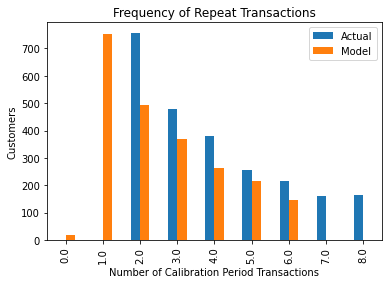

In [174]:
plot_period_transactions(betageo)
plt.show()


---
# **12. Establishment of GAMMA-GAMMA Model**

### **GammaGammaFitter** is a class in the lifetimes package in Python that can be used to estimate the parameters of the Gamma-Gamma submodel of the Pareto/NBD model for customer lifetime value (CLV) analysis. The Gamma-Gamma submodel estimates the distribution of the monetary value of each transaction, given that a customer has made a purchase.In another words it is used **to model the variability in the monetary value of customer transactions, given that a customer has made at least one transaction.**

### To use GammaGammaFitter with a lifetimes dataset,** you first need to fit a BetaGeoFitter model to the dataset to estimate the customer "lifetime" parameters** (i.e., the frequency, recency, and age distributions). 
### Once you have fitted the BetaGeoFitter model, you can use it to estimate the customer expected lifetime value and the conditional expected transaction value for each customer. Then, you can use the GammaGammaFitter class to estimate the parameters of the Gamma-Gamma submodel based on the conditional expected transaction values.

## **Here is a breakdown of the code:**
---

### **ggf = GammaGammaFitter(penalizer_coef=0.01)** The penalizer_coef parameter is **set to a small positive value to prevent overfitting** of the model.

### **ggf.fit(cltv_gb['frequency'], cltv_gb['monetary'])** fits the GammaGamma model to the dataset. 

### After fitting the GammaGammaFitter model, you can use its **conditional_expected_average_profit()** method to estimate the conditional expected transaction value for each customer, and the **expected_average_profit()** method to estimate the overall expected transaction value.

### Here, **cltv_gb['expected_average_profit']** will be a new column in the cltv_gb DataFrame that contains the estimated conditional expected transaction value for each customer, and expected_transaction_value will be a scalar value representing the estimated overall expected transaction value.

In [175]:
gamma = GammaGammaFitter(penalizer_coef=0.01)

gamma.fit(cltv_gb['frequency'], cltv_gb['monetary'])

gamma.conditional_expected_average_profit(cltv_gb['frequency'],
                                        cltv_gb['monetary']).head(10)


Customer ID
12346.0000      5.9164
12347.0000    926.0180
12349.0000    669.8791
12352.0000    242.3264
12356.0000   1465.7129
12357.0000   7875.3304
12358.0000   1119.0847
12359.0000    332.5792
12360.0000    286.0845
12361.0000    133.4855
dtype: float64

In [176]:
cltv_gb["expected_average_profit"] = gamma.conditional_expected_average_profit(cltv_gb['frequency'],
                                                                             cltv_gb['monetary'])
cltv_gb.sort_values("expected_average_profit", ascending=False).head(10)


,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12357.0000,0.0000,55.5714,2,5639.7750,0.0000,0.0001,0.0004,7875.3304
14091.0000,6.2857,99.8571,2,4555.4250,0.0000,0.0001,0.0004,6361.6074
17450.0000,10.0000,62.7143,8,3350.8900,0.0000,0.0000,0.0000,3607.1044
18102.0000,53.2857,105.5714,95,3155.5607,0.0000,0.0000,0.0000,3174.5536
16749.0000,18.8571,103.5714,2,2193.5400,0.0005,0.0018,0.0053,3064.4806
12415.0000,21.7143,75.4286,7,2776.0314,0.0001,0.0002,0.0006,3021.3784
12477.0000,31.8571,89.1429,3,2352.2100,0.0026,0.0102,0.0295,2902.1376
14646.0000,51.7143,105.4286,87,2715.6506,0.0000,0.0000,0.0000,2733.5141
13935.0000,7.8571,93.2857,3,2038.9733,0.0000,0.0001,0.0002,2515.8537


---
# **13. Calculation of CLTV with BG-NBD and Gamma-Gamma Model**

### The **customer_lifetime_value()** method in the GammaGammaFitter class can be used to estimate the customer lifetime value (CLV) of each customer in the dataset based on the Beta-GeoFitter model and the Gamma-Gamma submodel. 

### This method takes as input the fitted Beta-GeoFitter model (betageo), the frequency, recency, and age(T) data for each customer, the monetary value of each transaction (monetary), the time horizon over which to estimate CLV (in this case, 3 months), the frequency of the data (freq), and the discount rate to use in the estimation.

### Here, betageo is the fitted BetaGeoFitter model object, cltv_gb['frequency'], cltv_gb['recency'], cltv_gb['T'], and cltv_gb['monetary'] are Pandas Series containing the frequency, recency, age, and monetary data for each customer in the dataset, time=3 specifies that the CLV should be estimated over a 3-month time horizon, freq="W" specifies that the data is in weekly frequency, and discount_rate=0.01 specifies the discount rate to use in the estimation.

In [177]:
cltv = gamma.customer_lifetime_value(betageo,
                                   cltv_gb['frequency'],
                                   cltv_gb['recency'],
                                   cltv_gb['T'],
                                   cltv_gb['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

Customer ID
12346.0000    0.0001
12347.0000    3.5030
12349.0000   26.7684
12352.0000    0.3275
12356.0000    1.6622
Name: clv, dtype: float64

In [178]:
cltv = cltv.reset_index()

cltv_final = cltv_gb.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
95,12557.0000,50.1429,103.2857,4,1681.2950,0.0052,0.0204,0.0591,1960.1402,122.7644
74,12497.0000,40.1429,97.5714,3,1685.4433,0.0040,0.0157,0.0455,2079.8801,100.2747
6,12358.0000,50.8571,104.5714,3,906.3367,0.0069,0.0273,0.0792,1119.0847,94.0750
488,13373.0000,45.2857,104.8571,3,1424.9800,0.0044,0.0173,0.0503,1758.6763,93.8659
63,12477.0000,31.8571,89.1429,3,2352.2100,0.0026,0.0102,0.0295,2902.1376,90.7315
247,12873.0000,40.5714,97.4286,2,826.6500,0.0060,0.0236,0.0687,1156.3395,84.2998
45,12435.0000,48.5714,105.4286,4,1431.8725,0.0039,0.0155,0.0448,1669.4967,79.3326
433,13253.0000,39.0000,100.5714,2,960.3550,0.0047,0.0185,0.0539,1342.9880,76.7695
90,12539.0000,37.8571,102.4286,3,1882.1333,0.0024,0.0096,0.0280,2322.4384,69.0097
16,12377.0000,29.7143,84.2857,2,899.1000,0.0044,0.0175,0.0505,1257.4777,67.3877


# **14. Creating Segments by CLTV**



*  ##   **With QCUT**




In [179]:
cltv_final_qcut=cltv_final.copy()

In [180]:
cltv_final_qcut["segment"] = pd.qcut(cltv_final_qcut["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final_qcut

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12346.0000,42.0000,103.7143,15,5.4673,0.0000,0.0000,0.0000,5.9164,0.0001,D
1,12347.0000,5.2857,57.8571,2,661.6600,0.0003,0.0013,0.0036,926.0180,3.5030,B
2,12349.0000,46.7143,105.1429,4,574.0275,0.0033,0.0130,0.0377,669.8791,26.7684,A
3,12352.0000,2.2857,56.1429,2,171.9000,0.0001,0.0004,0.0013,242.3264,0.3275,C
4,12356.0000,6.2857,60.7143,3,1187.4167,0.0001,0.0004,0.0011,1465.7129,1.6622,B
...,...,...,...,...,...,...,...,...,...,...,...
3079,18280.0000,1.8571,56.4286,2,145.9250,0.0001,0.0004,0.0010,206.0660,0.2235,C
3080,18283.0000,39.2857,94.1429,6,106.9617,0.0010,0.0038,0.0110,118.7531,1.3884,B
3081,18284.0000,0.2857,61.7143,2,218.1200,0.0000,0.0001,0.0003,306.8483,0.0984,C
3082,18286.0000,35.2857,103.4286,3,395.9967,0.0018,0.0069,0.0201,489.7327,10.4321,A


In [181]:
cltv_final_qcut.groupby("segment").agg(
    {'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'clv': ['mean', 'count']})

recency frequency monetary     clv      
           mean      mean     mean    mean count
segment                                         
D       23.7764   14.2776 253.6144  0.0153   771
C       22.1519    5.9741 258.8566  0.2846   771
B       29.0517    4.9572 312.6391  1.8283   771
A       35.9427    3.5966 381.9489 13.4714   771


*  ##   **With K-Means (Alternative)**


In [182]:
cltv_final_kmeans=cltv_final.copy()

In [183]:
# Standardize RFM metrics
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(cltv_final_kmeans)

In [193]:
# Create and analyze RFM segments using K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(df_rfm_scaled)
cltv_final_kmeans['segment'] = kmeans.labels_

cltv_final_kmeans['segment'] = cltv_final_kmeans['segment'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

In [194]:
# Analyze RFM segments
cltv_final_kmeans.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'clv': ['mean', 'count']
})

recency frequency  monetary     clv      
           mean      mean      mean    mean count
segment                                          
A       40.3868    3.0738  316.2796 19.4197   366
B       39.4619   11.1238  273.4759  1.9500  1414
C       23.6607    9.4333 1237.3896  7.9260   120
D       10.2208    3.5667  236.2352  1.0231  1184


# **15. Functionalization - II**

In [186]:
def CLTV_BetaGeoGamma(dataframe, month=3):
    # 1. Data Preparation
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    #-------------------------------------------------------------------------------------------------------------------------
    replace_with_thresholds(dataframe, "Quantity") # get rid of outliers
    replace_with_thresholds(dataframe, "Price")    # get rid of outliers
    #-------------------------------------------------------------------------------------------------------------------------
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)
    #-------------------------------------------------------------------------------------------------------------------------
    cltv_gb = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice':      lambda Invoice: Invoice.nunique(),
         'TotalPrice':   lambda TotalPrice: TotalPrice.sum()})

    cltv_gb.columns = cltv_gb.columns.droplevel(0)  # The resulting column will have a single level of column headers.
    cltv_gb.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_gb["monetary"] = cltv_gb["monetary"] / cltv_gb["frequency"]
    cltv_gb = cltv_gb[(cltv_gb['frequency'] > 1)]
    cltv_gb["recency"] = cltv_gb["recency"] / 7
    cltv_gb["T"] = cltv_gb["T"] / 7
    #-------------------------------------------------------------------------------------------------------------------------
    # 2. Establishment of BG-NBD Model
    betageo = BetaGeoFitter(penalizer_coef=0.001)
    betageo.fit(cltv_gb['frequency'],
            cltv_gb['recency'],
            cltv_gb['T'])

    cltv_gb["expected_purc_1_week"] = betageo.predict(1,
                                                  cltv_gb['frequency'],
                                                  cltv_gb['recency'],
                                                  cltv_gb['T'])

    cltv_gb["expected_purc_1_month"] = betageo.predict(4,
                                                   cltv_gb['frequency'],
                                                   cltv_gb['recency'],
                                                   cltv_gb['T'])

    cltv_gb["expected_purc_3_month"] = betageo.predict(12,
                                                   cltv_gb['frequency'],
                                                   cltv_gb['recency'],
                                                   cltv_gb['T'])
    #-------------------------------------------------------------------------------------------------------------------------
    # 3. Establishing the GAMMA-GAMMA Model
    gamma = GammaGammaFitter(penalizer_coef=0.01)
    gamma.fit(cltv_gb['frequency'], cltv_gb['monetary'])
    cltv_gb["expected_average_profit"] = gamma.conditional_expected_average_profit(cltv_gb['frequency'],
                                                                                 cltv_gb['monetary'])
    #-------------------------------------------------------------------------------------------------------------------------
    # 4. Calculation of CLTV with BG-NBD and GG model
    cltv = gamma.customer_lifetime_value(betageo,
                                       cltv_gb['frequency'],
                                       cltv_gb['recency'],
                                       cltv_gb['T'],
                                       cltv_gb['monetary'],
                                       time=month,             # 3 month
                                       freq="W",               # Frequency information of T
                                       discount_rate=0.01)
    #-------------------------------------------------------------------------------------------------------------------------
    # 5. Creating Segments by CLTV
    cltv = cltv.reset_index()
    cltv_final = cltv_gb.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final



In [187]:
df = df_.copy()
cltv_final2 = CLTV_BetaGeoGamma(df)
cltv_final2

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12346.0000,28.0000,103.7143,11,33.8964,0.0000,0.0000,0.0000,34.7855,0.0002,D
1,12347.0000,5.2857,57.8571,2,661.6600,0.0004,0.0015,0.0043,726.7538,3.2751,B
2,12349.0000,25.8571,84.2857,3,765.0067,0.0014,0.0056,0.0160,813.4300,13.7464,A
3,12352.0000,2.2857,56.1429,2,171.9000,0.0002,0.0007,0.0019,190.3223,0.3763,C
4,12356.0000,6.2857,60.7143,3,1187.4167,0.0001,0.0005,0.0014,1261.8495,1.9081,B
...,...,...,...,...,...,...,...,...,...,...,...
2888,18276.0000,48.0000,104.2857,5,264.1320,0.0023,0.0092,0.0265,274.4279,7.6970,A
2889,18277.0000,13.8571,70.7143,4,256.6650,0.0002,0.0007,0.0019,269.3124,0.5392,C
2890,18283.0000,39.2857,94.1429,6,106.9617,0.0009,0.0036,0.0104,110.7961,1.2207,C
2891,18286.0000,35.2857,103.4286,2,641.6850,0.0026,0.0103,0.0300,704.8753,22.4203,A


In [188]:
cltv_final2.to_csv("cltv_prediction.csv")